# Evaluation - MPCs: Omniscient, Deterministic, Stochastic, Recourse

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cp
import os

from EnergyHub.env_EH_v1 import EHv1
from MPC.agent_mpc_det_week import MPCdetv0week
from MPC.agent_mpc_stoch_v1week import MPCstochv2week
from MPC.agent_mpc_stoch_rec_v1week import MPCstochv3week

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [2]:
resFolder = "Results"
if not os.path.exists(resFolder):
    os.makedirs(resFolder)

In [ ]:
# evaluation settings
n_episodes_per_season_test = 2 # 70 
n_days_per_episode_test = 1 # 7 for weekly episodes
alphas_test = [0.1] # significance level
saveVarsEnvAgent_test = True # required to make figures. set to False for the 280-day evaluation

In [4]:
# plot settings
e_plot = 4 #  4 82
noTitlePlots = True 
plot_power_max = 150 #* env.scale_pv
plot_power_min = -75 #* env.scale_pv
plot_grid_max = 125 #* env.scale_pv
plot_grid_min = -175 #* env.scale_pv
plot_bat_max = 125 #* scale_bat
plot_bat_min = -150 #* scale_bat

In [5]:
# EnergyHub settings
# BESS
scale_bat = 1
battery_config_opt_v4 = {
    'E_b_0': 0.25, # E_b[0] = E_b_0 * E_b_max
    'E_b_max': 90 * scale_bat, # kWh
    'E_b_min': 10 * scale_bat, # kWh
    'splines': np.array( # Single module battery scaled to 100kWh E_b
        [[ 63.47144295, 205.10911485], #
        [ 24.59458176, 360.84085873],
        [ 15.11269669, 459.47458218],
        [ 11.23026708, 517.65138388]]
        ) * scale_bat
        }

## MPC Omniscient

In [6]:
agent_config_omn = {
    'version': 'MPComn',
    'alphas': [],
    'n_eval_episodes_per_season': n_episodes_per_season_test,
    'n_eval_days_per_episode': n_days_per_episode_test,
    'norm_E_b_zero': 100 * scale_bat, # kWh
    'norm_p_zero': 100, # kW
    'norm_p_sc_zero': 1000 * scale_bat, # kW 
    'norm_cost_zero': 10, 
}

### evaluation

In [7]:
do_print_steps = False
do_save_agent = do_save_env = saveVarsEnvAgent_test
env = EHv1(battery_config=battery_config_opt_v4, agent_config=agent_config_omn, do_save_env_vars=do_save_env)
agent = MPCdetv0week(env=env, agent_config=agent_config_omn, do_save_agent_vars=do_save_agent)

reward_all = np.zeros(env.n_episodes)
E_b_real_all = {}
action_real_all = {}

p_g_all = {}
p_b_all = {}
p_i_all = {}
E_b_all = {}
res_load_all = {}
p_ev_all = {}
p_pv_all = {}
price_buy_all = {}
price_sell_all = {}

grid_actual_all = {}
reward_actual_all = {}
load_actual_all = {}
pv_actual_all = {}
price_actual_all = {}

for e in range(env.n_episodes):
    print('\n')
    print('------------------------------ Episode: %r SeasonId: %r SeasonEpId: %r ------------------------------' %(env.episode_id, env.season_id, env.season_episode_id))
    obs, _ = env.reset()
    if do_save_agent:
        agent = MPCdetv0week(env=env, agent_config=agent_config_omn, do_save_agent_vars=do_save_agent)
    episode_reward = 0
    done = False
    E_b_real = np.zeros((env.horizon_optimization * env.n_days_per_episode) + 1)
    action_real = np.zeros((env.horizon_optimization * env.n_days_per_episode))

    while not done:
        E_b_real[env.time_k] = obs

        if do_print_steps:
            print('time_k=' + str(env.time_k))
        a = agent.act(env=env, verbose=False)
        action_real[env.time_k] = a
        obs, rew, termination_flag, _, _ = env.step(action=a)
        if do_print_steps:
            mssg = " P_b(k): %.2f  E_b(k+1): %.3f  Cost_g(k): %.3f  Done: %r" % (a, obs, rew, termination_flag)
            print(mssg)
        done = termination_flag
        episode_reward += rew
        
    E_b_real[env.time_k + 1] = obs 

    reward_all[e] = episode_reward
    E_b_real_all[e] = E_b_real
    action_real_all[e] = action_real

    if do_save_agent:
        p_g_all[e] = agent.p_g
        p_b_all[e] = agent.p_b
        p_i_all[e] = agent.p_i
        E_b_all[e] = agent.E_b
        res_load_all[e] = agent.res_load
        p_ev_all[e] = agent.ev
        p_pv_all[e] = agent.pv
        price_buy_all[e] = agent.price_buy
        price_sell_all[e] = agent.price_sell

    if do_save_env:
        grid_actual_all[e] = env.grid_actual_save
        reward_actual_all[e] = env.reward_actual_save
        load_actual_all[e] = env.load_actual_save
        pv_actual_all[e] = env.pv_actual_save
        price_actual_all[e] = env.price_actual_save


/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/Control/EnergyHub/env_EH_v1.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  self.prob_array = np.array([1 / self.n_scenarios] * self.n_scenarios)




------------------------------ Episode: 0 SeasonId: 0 SeasonEpId: 0 ------------------------------
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-28


/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/Control/EnergyHub/utils.py:172: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season + 1)])
/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/Control/EnergyHub/utils.py:172: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season + 1)])




------------------------------ Episode: 1 SeasonId: 0 SeasonEpId: 1 ------------------------------


------------------------------ Episode: 2 SeasonId: 1 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 3 SeasonId: 1 SeasonEpId: 1 ------------------------------


------------------------------ Episode: 4 SeasonId: 2 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 5 SeasonId: 2 SeasonEpId: 1 ------------------------------


------------------------------ Episode: 6 SeasonId: 3 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 7 SeasonId: 3 SeasonEpId: 1 ------------------------------


### results

In [8]:
reward_all_det_omn = reward_all
reward_all_det_omn

array([ 27.09572896,  15.1878009 , -19.05829393,  -0.21416141,
        -2.20132956,  13.83913418,  -9.13569568, -65.87409727])

In [9]:
reward_all_det_omn.mean()

np.float64(-5.045114225785296)

In [10]:
e = e_plot

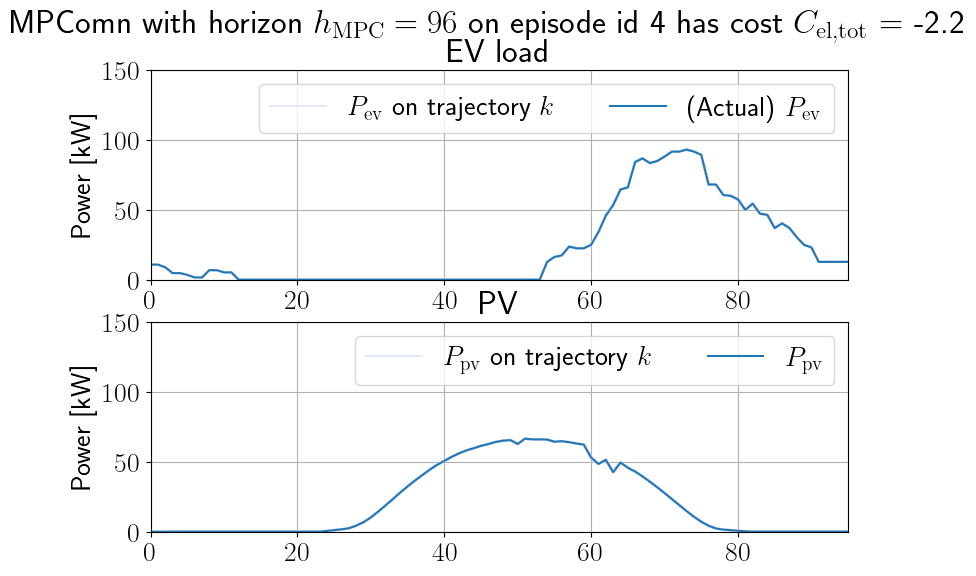

In [11]:
if saveVarsEnvAgent_test:
    fig, ax = plt.subplots(2, 1, figsize=(9, 6))
    fig.suptitle(fr"{agent_config_omn['version']} with horizon $h_\mathrm{{MPC}}={env.horizon_optimization}$ on episode id {e} has cost $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}")

    for start_hour, power_values in p_ev_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#E6E6FA', label=r'$P_{\mathrm{ev}}$ on trajectory $k$')
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test], label=r'(Actual) $P_\mathrm{ev}$')
    ax[0].set_title('EV load')
    ax[0].set_ylabel('Power [kW]')
    ax[0].set_xlim(0,96*n_days_per_episode_test-1)
    ax[0].set_ylim(0, plot_power_max)
    ax[0].legend(loc='upper right', ncol=2)  # Move legend outside
    ax[0].grid()

    for start_hour, power_values in p_pv_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:], color='#E6E6FA', label=r'$P_{\mathrm{pv}}$ on trajectory $k$')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_\mathrm{pv}$') # TODO
    ax[1].set_title('PV')
    ax[1].set_ylabel('Power [kW]')
    ax[1].set_xlim(0,96*n_days_per_episode_test-1)
    ax[1].set_ylim(0, plot_power_max)
    ax[1].legend(loc='upper right', ncol=2)  # Move legend outside
    ax[1].grid()



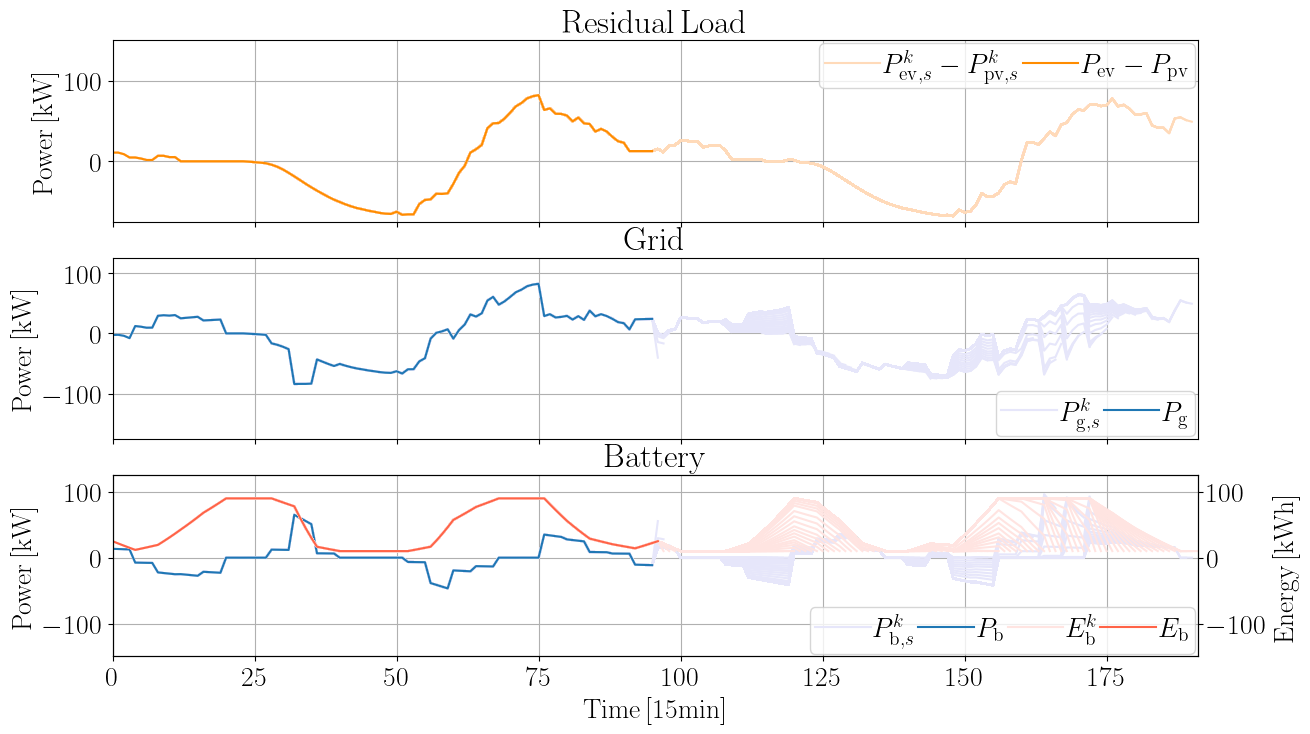

In [ ]:
if saveVarsEnvAgent_test:
    fig, ax = plt.subplots(3, 1, figsize=(14, 8))
    if not noTitlePlots:
        fig.suptitle(fr"{agent_config_omn['version']}, episode_i = {e}, $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}e")

    for start_hour, power_values in res_load_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#FFDAB9', label=r'$P_{\mathrm{ev}, s}^k - P_{\mathrm{pv}, s}^k$')
        else:
            ax[0].plot(hours, power_values[:], color='#FFDAB9', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test] - pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_\mathrm{ev} - P_\mathrm{pv}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Residual \, Load}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(plot_power_min, plot_power_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])


    for start_hour, power_values in p_g_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:], color='#E6E6FA', label=r'$P_{\mathrm{g}, s}^k$')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), grid_actual_all[e], label=r'$P_\mathrm{g}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(plot_grid_min, plot_grid_max)
    ax[1].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xticklabels([])

    for start_hour, power_values in p_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0:
            ax[2].plot(hours, power_values[:], color='#E6E6FA', label=r'$P_{\mathrm{b}, s}^k$')
        else:
            ax[2].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[2].plot(range(len(action_real)), action_real_all[e], label=r'$P_\mathrm{b}$')

    for start_hour, energy_values in E_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization + 1)
        if start_hour == 0:
            ax[2].plot(hours, energy_values[:], color='mistyrose', label=r'$E_{\mathrm{b}}^k$')
            
        else:
            ax[2].plot(hours, energy_values[:], color='mistyrose')

    ax[2].plot(range(len(E_b_real)), E_b_real_all[e], label=r'$E_\mathrm{b}$', color='tomato') # check E_b

    ax2_battery = ax[2].twinx()

    ax2_battery.set_ylabel(r'$\mathrm{Energy \, [kWh]}$')  # Label for the second y-axis
    ax2_battery.set_ylim(plot_bat_min, plot_bat_max)

    ax[2].set_title(r'$\mathrm{Battery}$')
    ax[2].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[2].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[2].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[2].set_ylim(plot_bat_min, plot_bat_max)
    ax[2].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[2].grid()
    # fig.savefig(f'{resFolder}/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')



### main plot

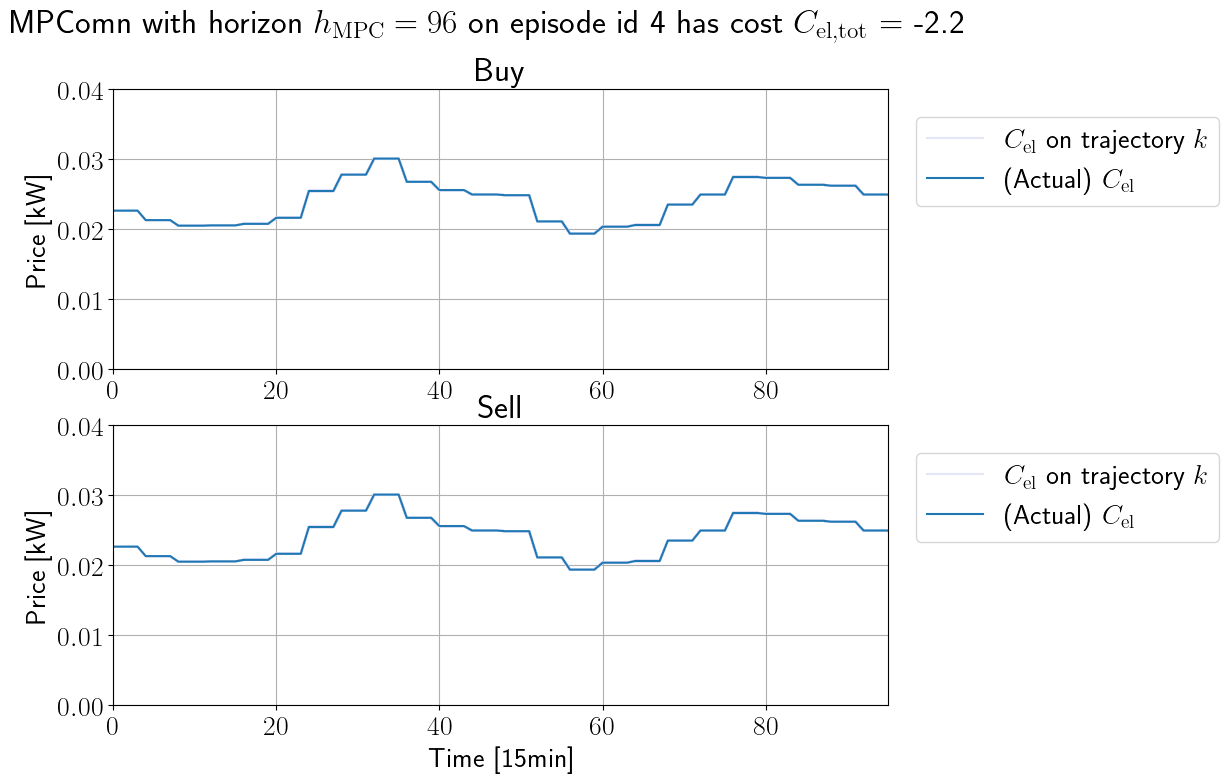

In [13]:
if saveVarsEnvAgent_test:
    plot_p_max = 0.02 *2
    plot_p_min = 0

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(fr"{agent_config_omn['version']} with horizon $h_\mathrm{{MPC}}={env.horizon_optimization}$ on episode id {e} has cost $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}")

    for start_hour, power_values in price_buy_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#E6E6FA', label=r'$C_{\mathrm{el}}$ on trajectory $k$')
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'(Actual) $C_\mathrm{el}$')
    ax[0].set_title('Buy')
    ax[0].set_ylabel('Price [kW]')
    ax[0].set_xlim(0,96*n_days_per_episode_test-1)
    ax[0].set_ylim(plot_p_min, plot_p_max)
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[0].grid()

    for start_hour, power_values in price_sell_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:], color='#E6E6FA', label=r'$C_{\mathrm{el}}$ on trajectory $k$')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test] * env.price_sell_prop_of_buy, label=r'(Actual) $C_\mathrm{el}$')
    ax[1].set_title('Sell')
    ax[1].set_ylabel('Price [kW]')
    ax[1].set_xlabel('Time [15min]')
    ax[1].set_xlim(0,96*n_days_per_episode_test-1)
    ax[1].set_ylim(plot_p_min, plot_p_max)
    ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[1].grid()


## MPC Deterministic

### evaluation

In [14]:
agent_config_det = {
    'version': 'MPCdet',
    'alphas': [],
    'n_eval_episodes_per_season': n_episodes_per_season_test,
    'n_eval_days_per_episode': n_days_per_episode_test,
    'norm_E_b_zero': 100 * scale_bat, # kWh
    'norm_p_zero': 100, # kW
    'norm_p_sc_zero': 1000 * scale_bat, # kW 
    'norm_cost_zero': 1,
}

In [15]:
do_print_steps = False
do_save_agent = do_save_env = saveVarsEnvAgent_test
env = EHv1(battery_config=battery_config_opt_v4, agent_config=agent_config_det, do_save_env_vars=do_save_env)
agent = MPCdetv0week(env=env, agent_config=agent_config_det, do_save_agent_vars=do_save_agent)

reward_all = np.zeros(env.n_episodes)
E_b_real_all = {}
action_real_all = {}

p_g_all = {}
p_b_all = {}
p_i_all = {}
E_b_all = {}
res_load_all = {}
p_ev_all = {}
p_pv_all = {}
price_buy_all = {}
price_sell_all = {}

grid_actual_all = {}
reward_actual_all = {}
load_actual_all = {}
pv_actual_all = {}
price_actual_all = {}

for e in range(env.n_episodes):
    print('\n')
    print('------------------------------ Episode: %r SeasonId: %r SeasonEpId: %r ------------------------------' %(env.episode_id, env.season_id, env.season_episode_id))
    obs, _ = env.reset()
    if do_save_agent:
        agent = MPCdetv0week(env=env, agent_config=agent_config_det, do_save_agent_vars=do_save_agent)
    episode_reward = 0
    done = False
    E_b_real = np.zeros((env.horizon_optimization * env.n_days_per_episode) + 1)
    action_real = np.zeros((env.horizon_optimization * env.n_days_per_episode))

    while not done:
        E_b_real[env.time_k] = obs

        if do_print_steps:
            print('time_k=' + str(env.time_k))
        a = agent.act(env=env, verbose=False)
        action_real[env.time_k] = a
        obs, rew, termination_flag, _, _ = env.step(action=a)
        if do_print_steps:
            mssg = " P_b(k): %.2f  E_b(k+1): %.3f  Cost_g(k): %.3f  Done: %r" % (a, obs, rew, termination_flag)
            print(mssg)
        done = termination_flag
        episode_reward += rew
        
    E_b_real[env.time_k + 1] = obs 
    print('Episode reward: %.2f' % episode_reward)

    reward_all[e] = episode_reward
    E_b_real_all[e] = E_b_real
    action_real_all[e] = action_real

    if do_save_agent:
        p_g_all[e] = agent.p_g
        p_b_all[e] = agent.p_b
        p_i_all[e] = agent.p_i
        E_b_all[e] = agent.E_b
        res_load_all[e] = agent.res_load
        p_ev_all[e] = agent.ev
        p_pv_all[e] = agent.pv
        price_buy_all[e] = agent.price_buy
        price_sell_all[e] = agent.price_sell

    if do_save_env:
        grid_actual_all[e] = env.grid_actual_save
        reward_actual_all[e] = env.reward_actual_save
        load_actual_all[e] = env.load_actual_save
        pv_actual_all[e] = env.pv_actual_save
        price_actual_all[e] = env.price_actual_save


/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/Control/EnergyHub/env_EH_v1.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  self.prob_array = np.array([1 / self.n_scenarios] * self.n_scenarios)
/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/Control/EnergyHub/utils.py:172: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season + 1)])
/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/Control/EnergyHub/utils.py:172: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries befo



------------------------------ Episode: 0 SeasonId: 0 SeasonEpId: 0 ------------------------------
Episode reward: 27.84


------------------------------ Episode: 1 SeasonId: 0 SeasonEpId: 1 ------------------------------
Episode reward: 17.38


------------------------------ Episode: 2 SeasonId: 1 SeasonEpId: 0 ------------------------------
Episode reward: -16.68


------------------------------ Episode: 3 SeasonId: 1 SeasonEpId: 1 ------------------------------
Episode reward: 2.03


------------------------------ Episode: 4 SeasonId: 2 SeasonEpId: 0 ------------------------------
Episode reward: -1.87


------------------------------ Episode: 5 SeasonId: 2 SeasonEpId: 1 ------------------------------
Episode reward: 14.28


------------------------------ Episode: 6 SeasonId: 3 SeasonEpId: 0 ------------------------------
Episode reward: -0.33


------------------------------ Episode: 7 SeasonId: 3 SeasonEpId: 1 ------------------------------
Episode reward: -52.38


### results

In [16]:
reward_all_det_van = reward_all
reward_all_det_van

array([ 27.84092511,  17.37647206, -16.68042108,   2.02987413,
        -1.87251269,  14.27739002,  -0.33098795, -52.37924323])

In [17]:
reward_all_det_van.mean()

np.float64(-1.2173129534211125)

In [18]:
e = e_plot

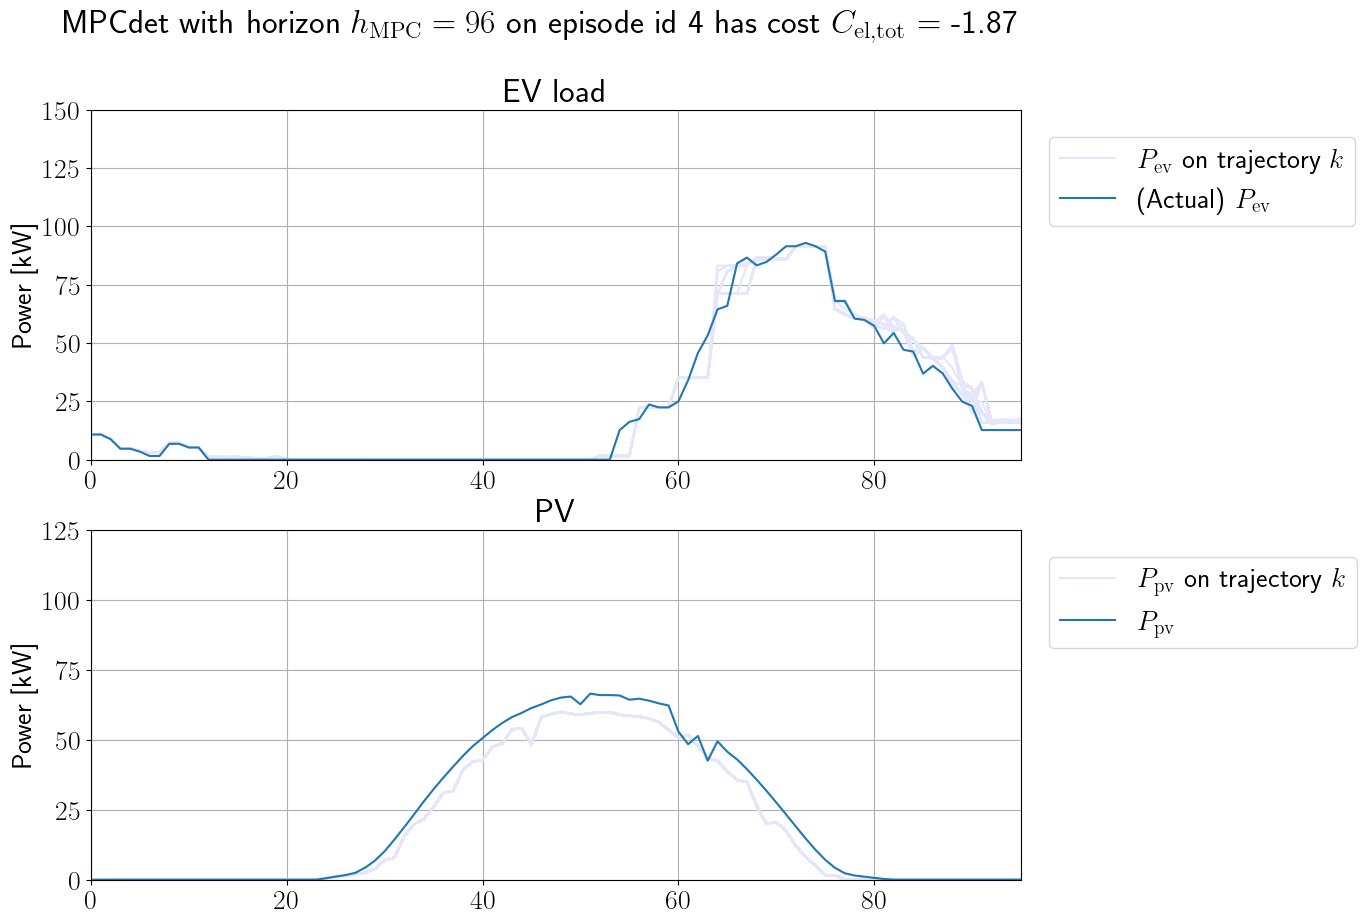

In [19]:
if saveVarsEnvAgent_test:
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(fr"{agent_config_det['version']} with horizon $h_\mathrm{{MPC}}={env.horizon_optimization}$ on episode id {e} has cost $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}")

    for start_hour, power_values in p_ev_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#E6E6FA', label=r'$P_{\mathrm{ev}}$ on trajectory $k$')
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test], label=r'(Actual) $P_\mathrm{ev}$')
    ax[0].set_title('EV load')
    ax[0].set_ylabel('Power [kW]')
    ax[0].set_xlim(0,96*n_days_per_episode_test-1)
    ax[0].set_ylim(0, plot_power_max)
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[0].grid()

    for start_hour, power_values in p_pv_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:], color='#E6E6FA', label=r'$P_{\mathrm{pv}}$ on trajectory $k$')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_\mathrm{pv}$') # TODO
    ax[1].set_title('PV')
    ax[1].set_ylabel('Power [kW]')
    ax[1].set_xlim(0,96*n_days_per_episode_test-1)
    ax[1].set_ylim(0, plot_grid_max)
    ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[1].grid()



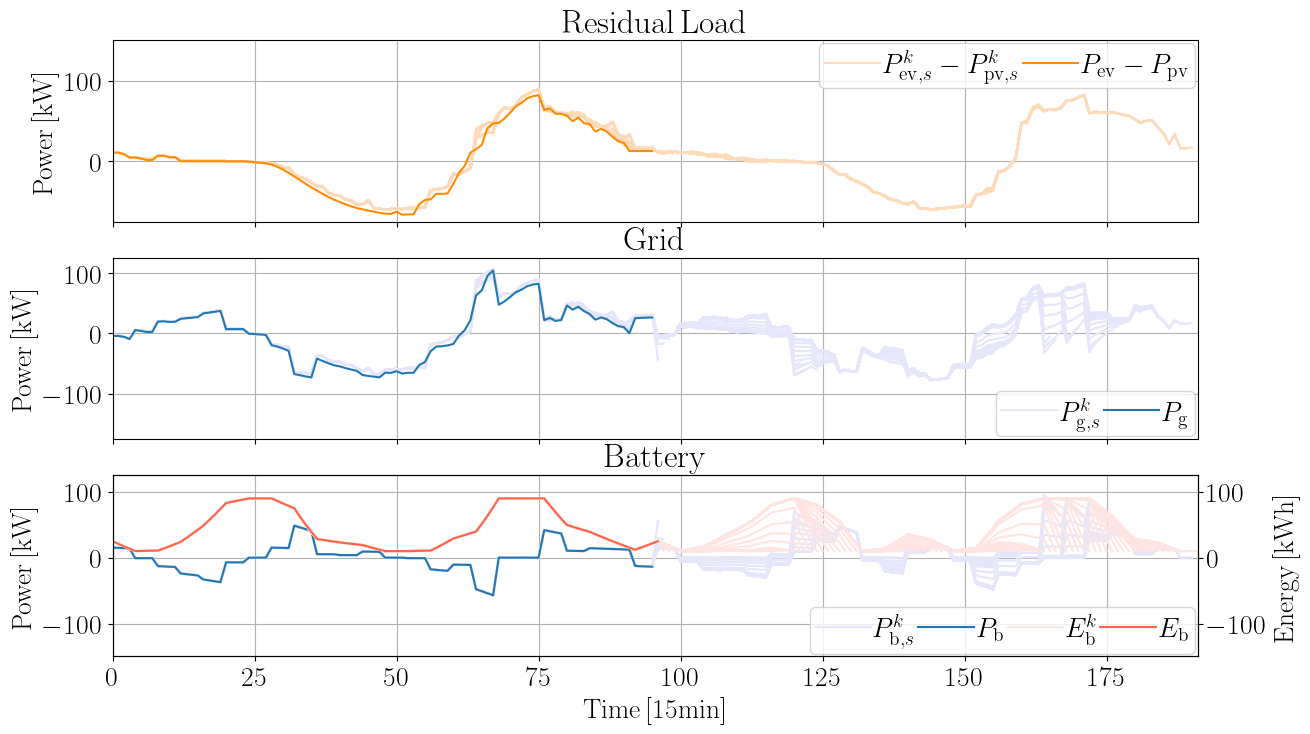

In [ ]:
if saveVarsEnvAgent_test:
    fig, ax = plt.subplots(3, 1, figsize=(14, 8))
    if not noTitlePlots:
        fig.suptitle(fr"{agent_config_det['version']}, episode_i = {e}, $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}e")

    for start_hour, power_values in res_load_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#FFDAB9', label=r'$P_{\mathrm{ev}, s}^k - P_{\mathrm{pv}, s}^k$')
        else:
            ax[0].plot(hours, power_values[:], color='#FFDAB9', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test] - pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_\mathrm{ev} - P_\mathrm{pv}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Residual \, Load}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(plot_power_min, plot_power_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])


    for start_hour, power_values in p_g_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:], color='#E6E6FA', label=r'$P_{\mathrm{g}, s}^k$')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), grid_actual_all[e], label=r'$P_\mathrm{g}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(plot_grid_min, plot_grid_max)
    ax[1].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xticklabels([])

    for start_hour, power_values in p_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0:
            ax[2].plot(hours, power_values[:], color='#E6E6FA', label=r'$P_{\mathrm{b}, s}^k$')
        else:
            ax[2].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[2].plot(range(len(action_real)), action_real_all[e], label=r'$P_\mathrm{b}$')

    for start_hour, energy_values in E_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization + 1)
        if start_hour == 0:
            ax[2].plot(hours, energy_values[:], color='mistyrose', label=r'$E_{\mathrm{b}}^k$')
            
        else:
            ax[2].plot(hours, energy_values[:], color='mistyrose')

    ax[2].plot(range(len(E_b_real)), E_b_real_all[e], label=r'$E_\mathrm{b}$', color='tomato') # check E_b

    ax2_battery = ax[2].twinx()

    ax2_battery.set_ylabel(r'$\mathrm{Energy \, [kWh]}$')  # Label for the second y-axis
    ax2_battery.set_ylim(plot_bat_min, plot_bat_max)

    ax[2].set_title(r'$\mathrm{Battery}$')
    ax[2].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[2].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[2].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[2].set_ylim(plot_bat_min, plot_bat_max)
    ax[2].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[2].grid()
    # fig.savefig(f'{resFolder}/MPCVan_{4*n_days_per_season_test}daysSeason_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCVan_{4*n_days_per_season_test}daysSeason_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')

### main plot

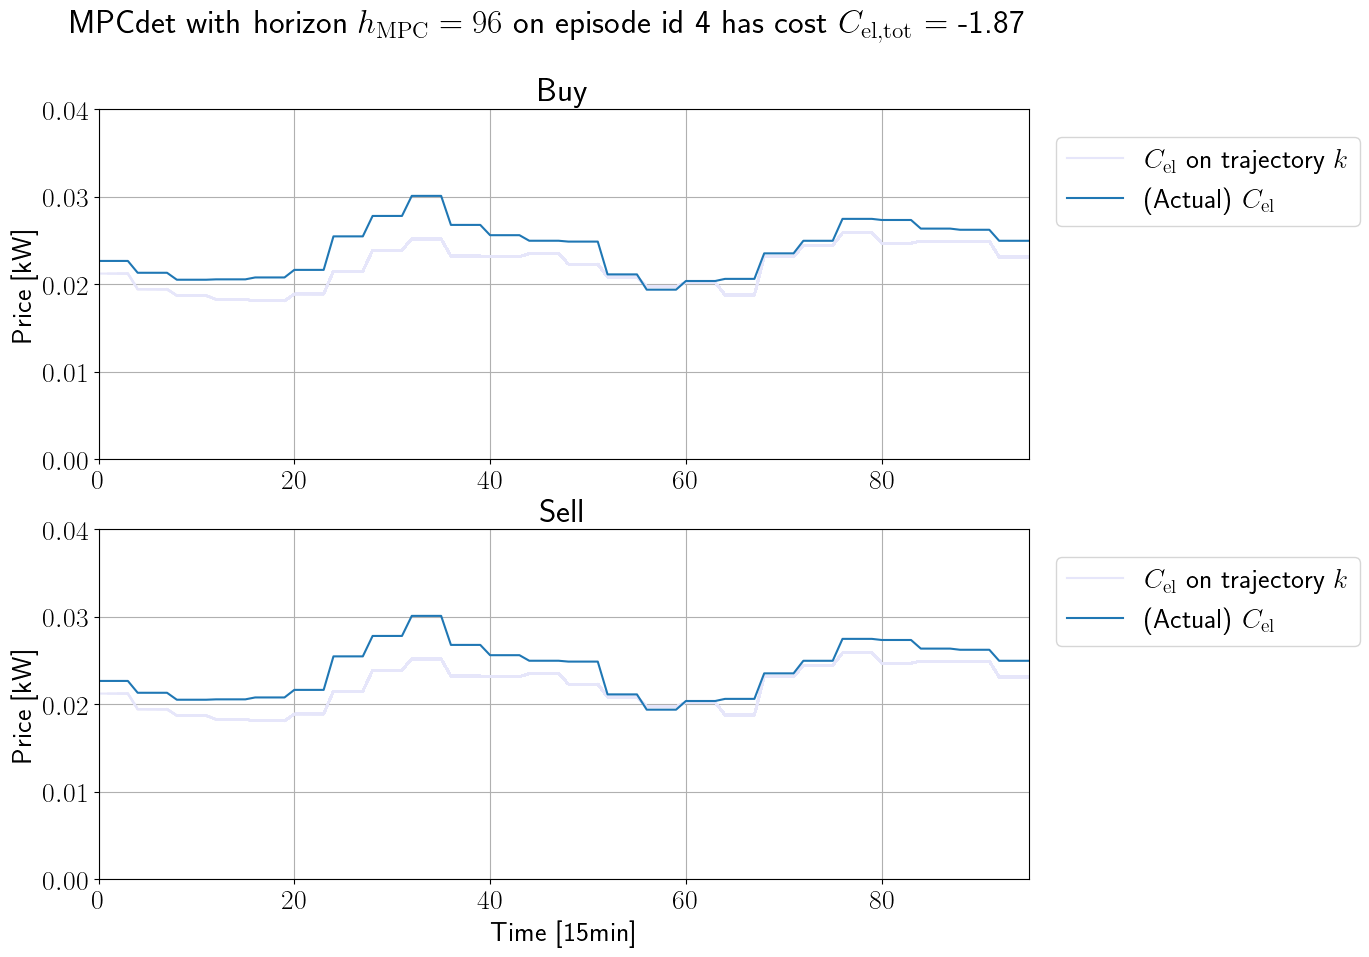

In [21]:
if saveVarsEnvAgent_test:
    plot_p_max = 0.02 * 2
    plot_p_min = 0

    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(fr"{agent_config_det['version']} with horizon $h_\mathrm{{MPC}}={env.horizon_optimization}$ on episode id {e} has cost $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}")

    for start_hour, power_values in price_buy_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#E6E6FA', label=r'$C_{\mathrm{el}}$ on trajectory $k$')
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'(Actual) $C_\mathrm{el}$')
    ax[0].set_title('Buy')
    ax[0].set_ylabel('Price [kW]')
    ax[0].set_xlim(0,96*n_days_per_episode_test-1)
    ax[0].set_ylim(plot_p_min, plot_p_max)
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[0].grid()

    for start_hour, power_values in price_sell_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:], color='#E6E6FA', label=r'$C_{\mathrm{el}}$ on trajectory $k$')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test] * env.price_sell_prop_of_buy, label=r'(Actual) $C_\mathrm{el}$')
    ax[1].set_title('Sell')
    ax[1].set_ylabel('Price [kW]')
    ax[1].set_xlabel('Time [15min]')
    ax[1].set_xlim(0,96*n_days_per_episode_test-1)
    ax[1].set_ylim(plot_p_min, plot_p_max)
    ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[1].grid()


## MPC Stochastic

In [22]:
agent_config_stoch = {
    'version': 'MPCstoch',
    'alphas': alphas_test,
    'n_eval_episodes_per_season': n_episodes_per_season_test,
    'n_eval_days_per_episode': n_days_per_episode_test,
    'norm_E_b_zero': 100 * scale_bat, # kWh
    'norm_p_zero': 100, # kW
    'norm_p_sc_zero': 1000 * scale_bat, # kW
    'norm_cost_zero': 1, 
}

### evaluation

In [23]:
do_print_steps = False
do_save_agent = do_save_env = saveVarsEnvAgent_test
env = EHv1(battery_config=battery_config_opt_v4, agent_config=agent_config_stoch, do_save_env_vars=do_save_env)
agent = MPCstochv2week(env=env, agent_config=agent_config_stoch, do_save_agent_vars=do_save_agent)

reward_all = np.zeros(env.n_episodes)
E_b_real_all = {}
action_real_all = {}

p_g_all = {}
p_b_all = {}
E_b_all = {}
res_load_all = {}
p_ev_all = {}
p_pv_all = {}
price_buy_all = {}
price_sell_all = {}

grid_actual_all = {}
reward_actual_all = {}
load_actual_all = {}
pv_actual_all = {}
price_actual_all = {}

for e in range(env.n_episodes):
    print('\n')
    print('------------------------------ Episode: %r SeasonId: %r SeasonEpId: %r ------------------------------' %(env.episode_id, env.season_id, env.season_episode_id))
    obs, _ = env.reset()
    if do_save_agent:
        agent = MPCstochv2week(env=env, agent_config=agent_config_stoch, do_save_agent_vars=do_save_agent)
    episode_reward = 0
    done = False
    E_b_real = np.zeros((env.horizon_optimization * env.n_days_per_episode) + 1)
    action_real = np.zeros((env.horizon_optimization * env.n_days_per_episode))
    

    while not done:
        E_b_real[env.time_k] = obs

        if do_print_steps:
            print('time_k=' + str(env.time_k))
        a = agent.act(env=env, verbose=False)
        action_real[env.time_k] = a
        obs, rew, termination_flag, _, _ = env.step(action=a)
        if do_print_steps:
            mssg = " P_b(k): %.2f  E_b(k+1): %.3f  Cost_g(k): %.3f  Done: %r" % (a, obs, rew, termination_flag)
            print(mssg)
        done = termination_flag
        episode_reward += rew
        
    E_b_real[env.time_k + 1] = obs 

    reward_all[e] = episode_reward
    E_b_real_all[e] = E_b_real
    action_real_all[e] = action_real

    if do_save_agent:
        p_g_all[e] = agent.p_g
        p_b_all[e] = agent.p_b
        E_b_all[e] = agent.E_b
        res_load_all[e] = agent.res_load
        p_ev_all[e] = agent.ev
        p_pv_all[e] = agent.pv
        price_buy_all[e] = agent.price_buy
        price_sell_all[e] = agent.price_sell

    if do_save_env:
        grid_actual_all[e] = env.grid_actual_save
        reward_actual_all[e] = env.reward_actual_save
        load_actual_all[e] = env.load_actual_save
        pv_actual_all[e] = env.pv_actual_save
        price_actual_all[e] = env.price_actual_save




------------------------------ Episode: 0 SeasonId: 0 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 1 SeasonId: 0 SeasonEpId: 1 ------------------------------


------------------------------ Episode: 2 SeasonId: 1 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 3 SeasonId: 1 SeasonEpId: 1 ------------------------------


------------------------------ Episode: 4 SeasonId: 2 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 5 SeasonId: 2 SeasonEpId: 1 ------------------------------


------------------------------ Episode: 6 SeasonId: 3 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 7 SeasonId: 3 SeasonEpId: 1 ------------------------------


<!-- ### problem formulation -->

### results

In [24]:
reward_all_stoch = reward_all
reward_all_stoch

array([ 27.82607571,  17.30400744, -16.92489714,   2.06734052,
        -1.82683168,  14.29326873,  -0.3198911 , -53.3204532 ])

In [25]:
reward_all_stoch.mean()

np.float64(-1.3626725897188043)

In [26]:
e = e_plot

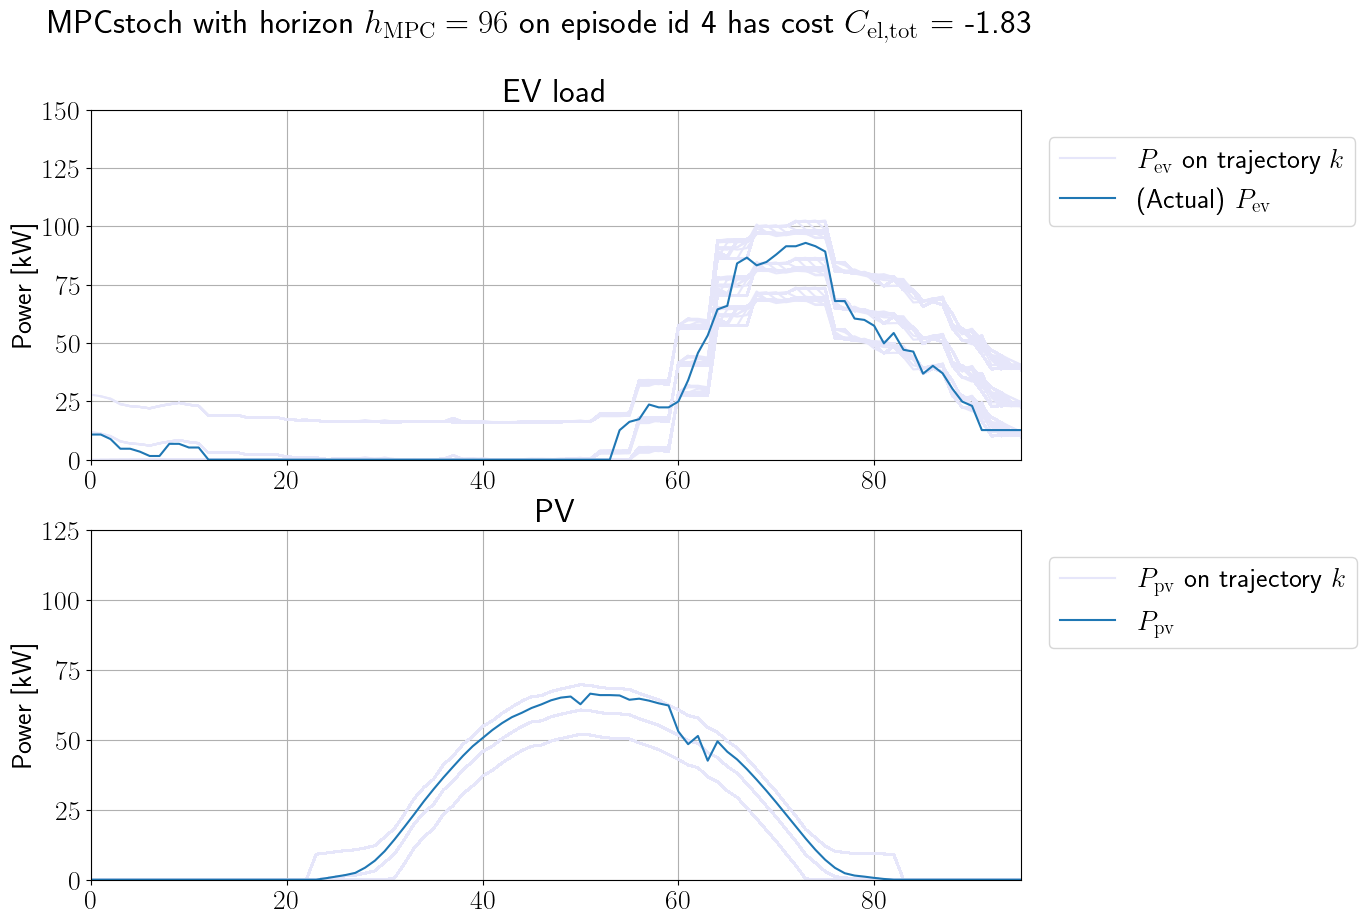

In [27]:
if saveVarsEnvAgent_test:
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(fr"{agent_config_stoch['version']} with horizon $h_\mathrm{{MPC}}={env.horizon_optimization}$ on episode id {e} has cost $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}")
    
    for start_hour, power_values in p_ev_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$P_{\mathrm{ev}}$ on trajectory $k$')
            ax[0].plot(hours, power_values[:, 1:], color='#E6E6FA')
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test], label=r'(Actual) $P_\mathrm{ev}$')
    ax[0].set_title('EV load')
    ax[0].set_ylabel('Power [kW]')
    ax[0].set_xlim(0,96*n_days_per_episode_test-1)
    ax[0].set_ylim(0, plot_power_max)
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[0].grid()

    for start_hour, power_values in p_pv_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$P_{\mathrm{pv}}$ on trajectory $k$')
            ax[1].plot(hours, power_values[:, 1:], color='#E6E6FA')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_\mathrm{pv}$') # TODO
    ax[1].set_title('PV')
    ax[1].set_ylabel('Power [kW]')
    ax[1].set_xlim(0,96*n_days_per_episode_test-1)
    ax[1].set_ylim(0, plot_grid_max)
    ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[1].grid()



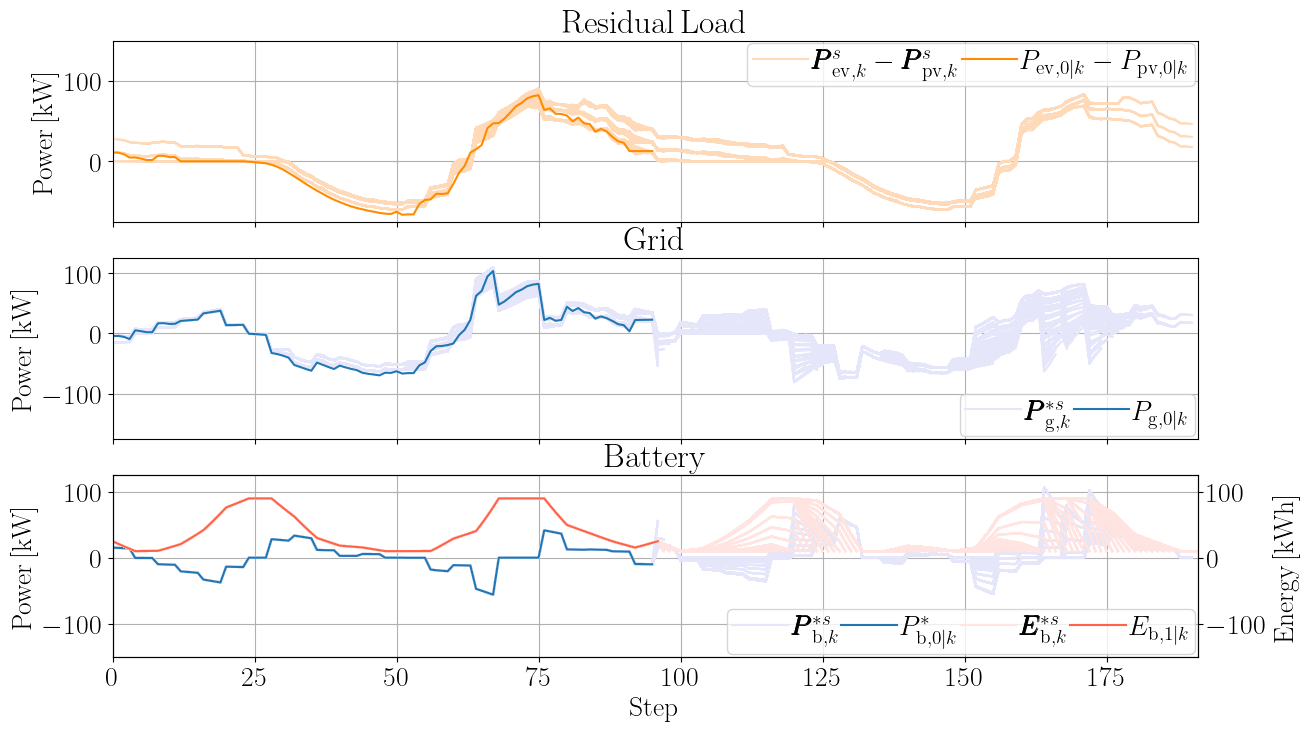

In [ ]:
if saveVarsEnvAgent_test:
    fig, ax = plt.subplots(3, 1, figsize=(14, 8))

    if not noTitlePlots:
        fig.suptitle(fr"{agent_config_stoch['version']}, episode_i = {e}, $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}e")

    for start_hour, power_values in res_load_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#FFDAB9', label=r'$\pmb{P}_{\mathrm{ev}, k}^s - \pmb{P}_{\mathrm{pv}, k}^s$')
            ax[0].plot(hours, power_values[:, 1:], color='#FFDAB9', ) 
        else:
            ax[0].plot(hours, power_values[:], color='#FFDAB9', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test] - pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{ev}, 0|k} - P_{\mathrm{pv}, 0|k}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Residual \, Load}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(plot_power_min, plot_power_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start_hour, power_values in p_g_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{g}, k}^{* s}$')
            ax[1].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), grid_actual_all[e], label=r'$P_{\mathrm{g}, 0|k}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(plot_grid_min, plot_grid_max)
    ax[1].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xticklabels([])

    for start_hour, power_values in p_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0:
            ax[2].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{b}, k}^{* s}$')
            ax[2].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[2].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[2].plot(range(len(action_real)), action_real_all[e], label=r'$P_{\mathrm{b}, 0|k}^*$')

    for start_hour, energy_values in E_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization + 1)
        if start_hour == 0:
            ax[2].plot(hours, energy_values[:, 0], color='mistyrose', label=r'$\pmb{E}_{\mathrm{b}, k}^{* s}$')
            ax[2].plot(hours, energy_values[:, 1:], color='mistyrose') 
        else:
            ax[2].plot(hours, energy_values[:], color='mistyrose') 

    ax[2].plot(range(len(E_b_real)), E_b_real_all[e], label=r'$E_{\mathrm{b}, 1|k}$', color='tomato') # check E_b

    ax2_battery = ax[2].twinx()

    ax2_battery.set_ylabel(r'$\mathrm{Energy \, [kWh]}$')  # Label for the second y-axis
    ax2_battery.set_ylim(plot_bat_min, plot_bat_max)

    ax[2].set_title(r'$\mathrm{Battery}$')
    ax[2].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[2].set_xlabel(r'$\mathrm{Step}$') # Time \, [15min]
    ax[2].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[2].set_ylim(plot_bat_min, plot_bat_max)
    ax[2].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[2].grid()
    # fig.savefig(f'{resFolder}/MPCSce_{4*n_days_per_season_test}daysSeason_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCSce_{4*n_days_per_episode_test*n_episodes_per_season_test}daysSeason_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')



### main plot

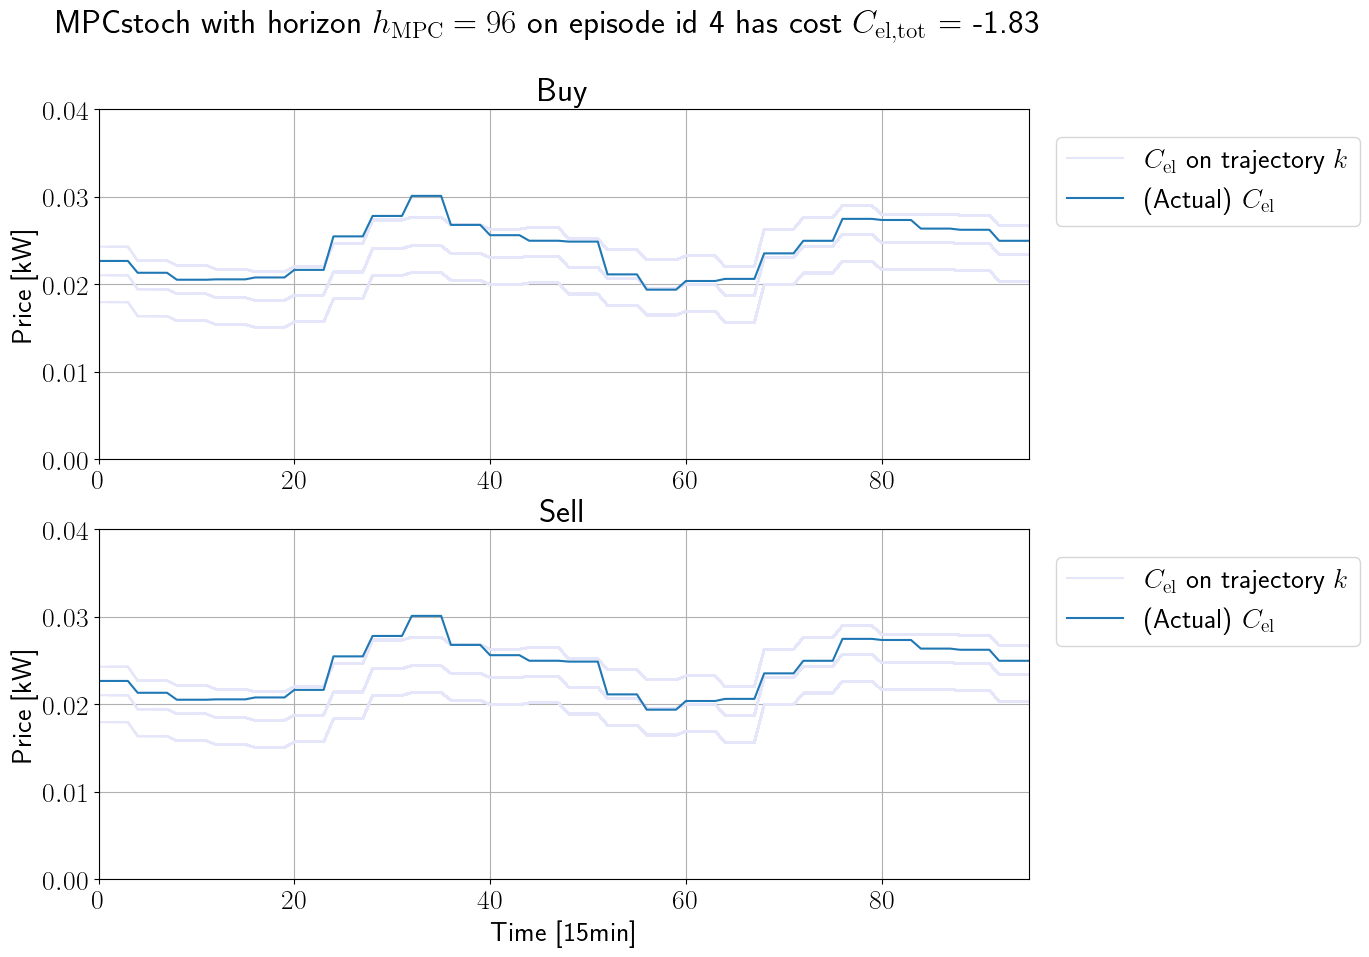

In [29]:
if saveVarsEnvAgent_test:
    plot_p_max = 0.02 * 2
    plot_p_min = 0

    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(fr"{agent_config_stoch['version']} with horizon $h_\mathrm{{MPC}}={env.horizon_optimization}$ on episode id {e} has cost $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}")

    for start_hour, power_values in price_buy_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$C_{\mathrm{el}}$ on trajectory $k$')
            ax[0].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'(Actual) $C_\mathrm{el}$')
    ax[0].set_title('Buy')
    ax[0].set_ylabel('Price [kW]')
    ax[0].set_xlim(0,96*n_days_per_episode_test-1)
    ax[0].set_ylim(plot_p_min, plot_p_max)
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[0].grid()

    for start_hour, power_values in price_sell_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$C_{\mathrm{el}}$ on trajectory $k$')
            ax[1].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test] * env.price_sell_prop_of_buy, label=r'(Actual) $C_\mathrm{el}$')
    ax[1].set_title('Sell')
    ax[1].set_ylabel('Price [kW]')
    ax[1].set_xlabel('Time [15min]')
    ax[1].set_xlim(0,96*n_days_per_episode_test-1)
    ax[1].set_ylim(plot_p_min, plot_p_max)
    ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[1].grid()


## MPC Recourse

In [30]:
agent_config_rec = {
    'version': 'MPCrec',
    'alphas': alphas_test,
    'n_eval_episodes_per_season': n_episodes_per_season_test,
    'n_eval_days_per_episode': n_days_per_episode_test,
    'norm_E_b_zero': 100 * scale_bat, # kWh
    'norm_p_zero': 100, # kW
    'norm_p_sc_zero': 1000 * scale_bat, # kW
    'norm_cost_zero': 1,
}

### evaluation

In [31]:
do_print_steps = False
do_save_agent = do_save_env = saveVarsEnvAgent_test
env = EHv1(battery_config=battery_config_opt_v4, agent_config=agent_config_rec, do_save_env_vars=do_save_env)
agent = MPCstochv3week(env=env, agent_config=agent_config_rec, do_save_agent_vars=do_save_agent)

reward_all = np.zeros(env.n_episodes)
E_b_real_all = {}
action_real_all = {}

p_g_all = {}
p_b_all = {}
E_b_all = {}
res_load_all = {}
p_ev_all = {}
p_pv_all = {}
price_buy_all = {}
price_sell_all = {}

grid_actual_all = {}
reward_actual_all = {}
load_actual_all = {}
pv_actual_all = {}
price_actual_all = {}

for e in range(env.n_episodes):
    print('\n')
    print('------------------------------ Episode: %r SeasonId: %r SeasonEpId: %r ------------------------------' %(env.episode_id, env.season_id, env.season_episode_id))
    obs, _ = env.reset()
    if do_save_agent:
        agent = MPCstochv3week(env=env, agent_config=agent_config_rec, do_save_agent_vars=do_save_agent)
    episode_reward = 0
    done = False
    E_b_real = np.zeros((env.horizon_optimization * env.n_days_per_episode) + 1)
    action_real = np.zeros((env.horizon_optimization * env.n_days_per_episode))

    while not done:
        E_b_real[env.time_k] = obs

        if do_print_steps:
            print('time_k=' + str(env.time_k))
        a = agent.act(env=env, verbose=False)
        action_real[env.time_k] = a
        obs, rew, termination_flag, _, _ = env.step(action=a)
        if do_print_steps:
            mssg = " P_b(k): %.2f  E_b(k+1): %.3f  Cost_g(k): %.3f  Done: %r" % (a, obs, rew, termination_flag)
            print(mssg)
        done = termination_flag
        episode_reward += rew
        
    E_b_real[env.time_k + 1] = obs 

    reward_all[e] = episode_reward
    E_b_real_all[e] = E_b_real
    action_real_all[e] = action_real

    if do_save_agent:
        p_g_all[e] = agent.p_g
        p_b_all[e] = agent.p_b
        E_b_all[e] = agent.E_b
        res_load_all[e] = agent.res_load
        p_ev_all[e] = agent.ev
        p_pv_all[e] = agent.pv
        price_buy_all[e] = agent.price_buy
        price_sell_all[e] = agent.price_sell

    if do_save_env:
        grid_actual_all[e] = env.grid_actual_save
        reward_actual_all[e] = env.reward_actual_save
        load_actual_all[e] = env.load_actual_save
        pv_actual_all[e] = env.pv_actual_save
        price_actual_all[e] = env.price_actual_save




------------------------------ Episode: 0 SeasonId: 0 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 1 SeasonId: 0 SeasonEpId: 1 ------------------------------


------------------------------ Episode: 2 SeasonId: 1 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 3 SeasonId: 1 SeasonEpId: 1 ------------------------------


------------------------------ Episode: 4 SeasonId: 2 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 5 SeasonId: 2 SeasonEpId: 1 ------------------------------


------------------------------ Episode: 6 SeasonId: 3 SeasonEpId: 0 ------------------------------


------------------------------ Episode: 7 SeasonId: 3 SeasonEpId: 1 ------------------------------


<!-- ### problem formulation -->

### results

In [32]:
reward_all_stoch_rec = reward_all
reward_all_stoch_rec

array([ 27.82450991,  17.31338535, -16.92703147,   2.06983933,
        -1.82710534,  14.29311201,  -0.31848938, -53.31896822])

In [33]:
reward_all_stoch_rec.mean()

np.float64(-1.3613434773368778)

In [34]:
e = e_plot

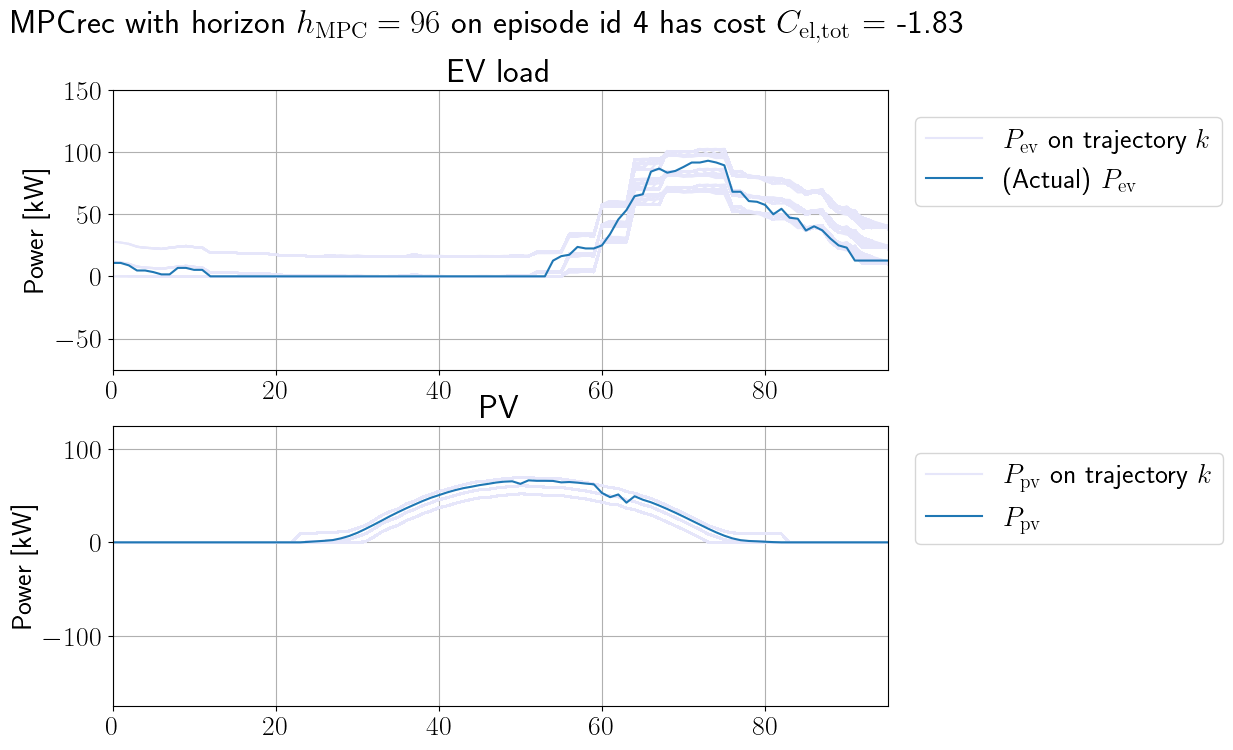

In [35]:
if saveVarsEnvAgent_test:
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(fr"{agent_config_rec['version']} with horizon $h_\mathrm{{MPC}}={env.horizon_optimization}$ on episode id {e} has cost $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}")

    for start_hour, power_values in p_ev_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$P_{\mathrm{ev}}$ on trajectory $k$')
            ax[0].plot(hours, power_values[:, 1:], color='#E6E6FA')
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test], label=r'(Actual) $P_\mathrm{ev}$')
    ax[0].set_title('EV load')
    ax[0].set_ylabel('Power [kW]')
    ax[0].set_xlim(0,96*n_days_per_episode_test-1)
    ax[0].set_ylim(plot_power_min, plot_power_max)
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[0].grid()

    for start_hour, power_values in p_pv_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$P_{\mathrm{pv}}$ on trajectory $k$')
            ax[1].plot(hours, power_values[:, 1:], color='#E6E6FA')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_\mathrm{pv}$') # TODO
    ax[1].set_title('PV')
    ax[1].set_ylabel('Power [kW]')
    ax[1].set_xlim(0,96*n_days_per_episode_test-1)
    ax[1].set_ylim(plot_grid_min, plot_grid_max)
    ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[1].grid()



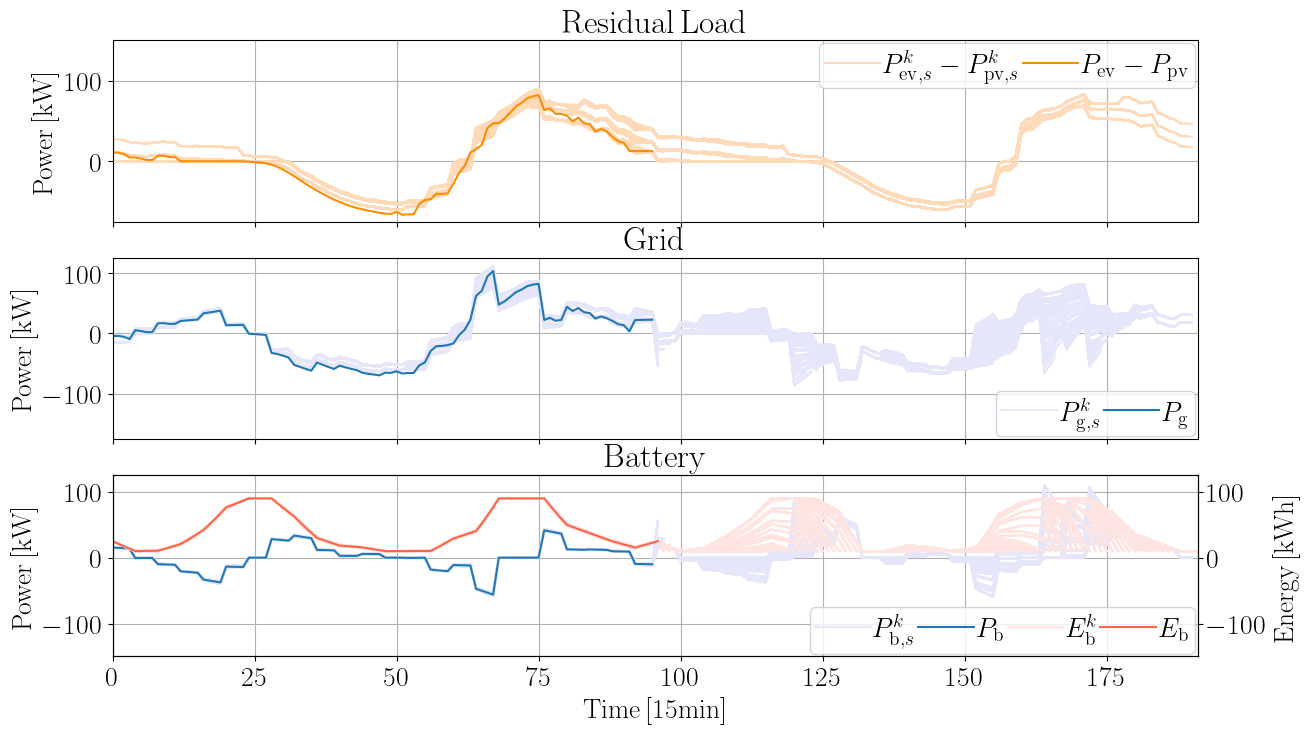

In [ ]:
if saveVarsEnvAgent_test:
    fig, ax = plt.subplots(3, 1, figsize=(14, 8))
    if not noTitlePlots:
        fig.suptitle(fr"{agent_config_rec['version']}, episode_i = {e}, $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}e")

    for start_hour, power_values in res_load_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#FFDAB9', label=r'$P_{\mathrm{ev}, s}^k - P_{\mathrm{pv}, s}^k$')
            ax[0].plot(hours, power_values[:, 1:], color='#FFDAB9', ) 
        else:
            ax[0].plot(hours, power_values[:], color='#FFDAB9', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test] - pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_\mathrm{ev} - P_\mathrm{pv}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Residual \, Load}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(plot_power_min, plot_power_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start_hour, power_values in p_g_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$P_{\mathrm{g}, s}^k$')
            ax[1].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), grid_actual_all[e], label=r'$P_\mathrm{g}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(plot_grid_min, plot_grid_max)
    ax[1].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xticklabels([])

    for start_hour, power_values in p_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0:
            ax[2].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$P_{\mathrm{b}, s}^k$')
            ax[2].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[2].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[2].plot(range(len(action_real)), action_real_all[e], label=r'$P_\mathrm{b}$')

    for start_hour, energy_values in E_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization + 1)
        if start_hour == 0:
            ax[2].plot(hours, energy_values[:, 0], color='mistyrose', label=r'$E_{\mathrm{b}}^k$')
            ax[2].plot(hours, energy_values[:, 1:], color='mistyrose') 
        else:
            ax[2].plot(hours, energy_values[:], color='mistyrose') 

    ax[2].plot(range(len(E_b_real)), E_b_real_all[e], label=r'$E_\mathrm{b}$', color='tomato') # check E_b

    ax2_battery = ax[2].twinx()

    # Plot the energy on the secondary y-axis
    # ax2_battery.plot(range(len(E_b_real)), E_b_real, color='tab:orange', label=r'(Realized) $E_\mathrm{b}$')
    ax2_battery.set_ylabel(r'$\mathrm{Energy \, [kWh]}$')  # Label for the second y-axis
    ax2_battery.set_ylim(plot_bat_min, plot_bat_max)

    ax[2].set_title(r'$\mathrm{Battery}$')
    ax[2].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[2].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[2].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[2].set_ylim(plot_bat_min, plot_bat_max)
    ax[2].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[2].grid()
    # fig.savefig(f'{resFolder}/MPCRec_{4*n_days_per_season_test}daysSeason_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCRec_{4*n_days_per_season_test}daysSeason_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')




### main plot

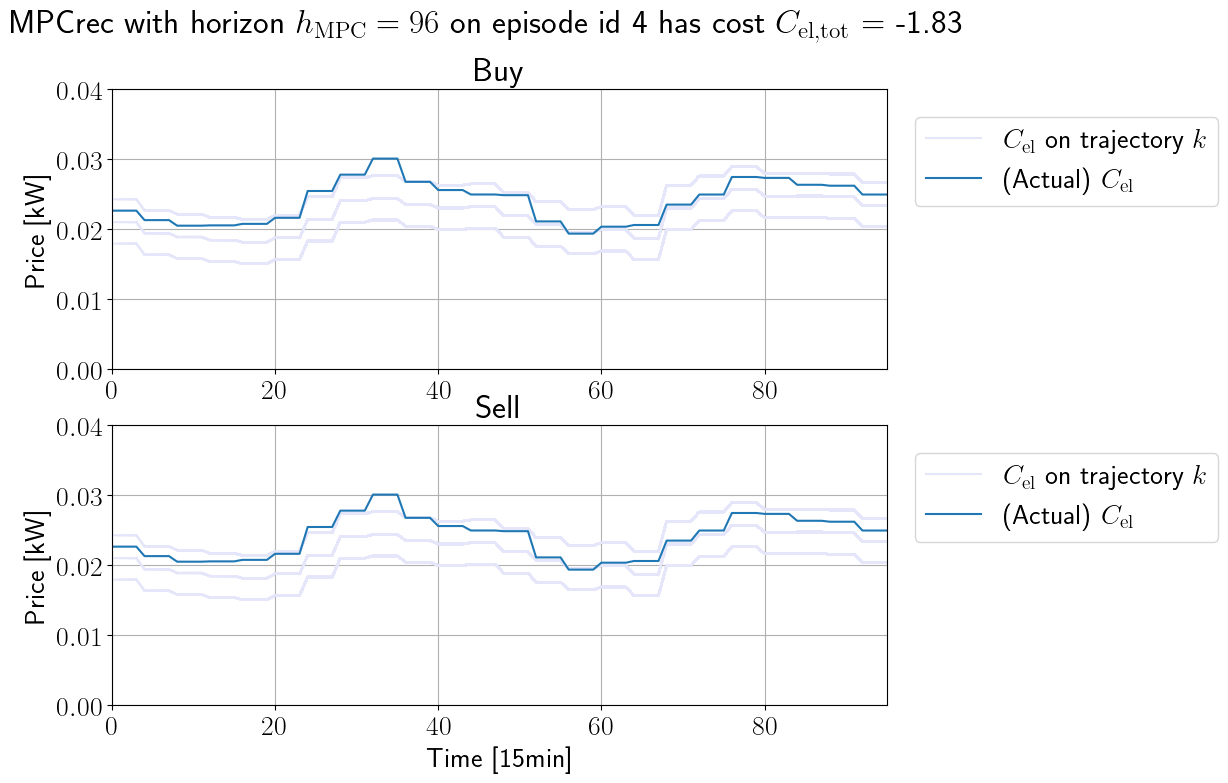

In [37]:
if saveVarsEnvAgent_test:
    plot_p_max = 0.02 * 2
    plot_p_min = 0

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(fr"{agent_config_rec['version']} with horizon $h_\mathrm{{MPC}}={env.horizon_optimization}$ on episode id {e} has cost $C_\mathrm{{el, tot}}$ = {round(reward_all[e], 2)}")

    for start_hour, power_values in price_buy_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$C_{\mathrm{el}}$ on trajectory $k$')
            ax[0].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'(Actual) $C_\mathrm{el}$')
    ax[0].set_title('Buy')
    ax[0].set_ylabel('Price [kW]')
    ax[0].set_xlim(0,96*n_days_per_episode_test-1)
    ax[0].set_ylim(plot_p_min, plot_p_max)
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[0].grid()

    for start_hour, power_values in price_sell_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$C_{\mathrm{el}}$ on trajectory $k$')
            ax[1].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test] * env.price_sell_prop_of_buy, label=r'(Actual) $C_\mathrm{el}$')
    ax[1].set_title('Sell')
    ax[1].set_ylabel('Price [kW]')
    ax[1].set_xlabel('Time [15min]')
    ax[1].set_xlim(0,96*n_days_per_episode_test-1)
    ax[1].set_ylim(plot_p_min, plot_p_max)
    ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)  # Move legend outside
    ax[1].grid()


<!-- ### plot results -->

## Comparison

In [39]:
# from the 280-day evaluation 
runtimeScenario = 208
runtimeRec = 169
runtimeVan = 90
runtimeOmn = 12
print(f"Time per episode \n Omn MPC: {runtimeOmn / (n_episodes_per_season_test * n_days_per_episode_test * 4):.4f} mins \n Vanilla MPC: {runtimeVan / (n_episodes_per_season_test * n_days_per_episode_test * 4):.4f} mins \n Scenario MPC: {runtimeScenario / (n_episodes_per_season_test * n_days_per_episode_test * 4):.4f} mins \n Recourse MPC: {runtimeRec / (n_episodes_per_season_test * n_days_per_episode_test * 4):.4f} mins")
print(f"Diff per episode \n Omn MPC: {(runtimeOmn) / runtimeScenario:.4f} \n Vanilla MPC: {(runtimeVan) / (runtimeScenario):.4f} \n Scenario MPC: {(runtimeScenario) / (runtimeScenario):.4f} \n Recourse MPC: {runtimeRec / (runtimeScenario):.4f} ")

Time per episode 
 Omn MPC: 1.5000 mins 
 Vanilla MPC: 11.2500 mins 
 Scenario MPC: 26.0000 mins 
 Recourse MPC: 21.1250 mins
Diff per episode 
 Omn MPC: 0.0577 
 Vanilla MPC: 0.4327 
 Scenario MPC: 1.0000 
 Recourse MPC: 0.8125 


In [40]:
rewards_df = pd.DataFrame({
                            'omn': reward_all_det_omn,
                            'det': reward_all_det_van,
                            'stoch': reward_all_stoch,
                            'rec': reward_all_stoch_rec,
                        })

In [41]:
# cols = ['omn', 'vanilla', 'scenario', 'recourse']
# rewards_df[cols] = rewards_df[cols].div(np.abs(rewards_df['omn']), axis=0)
rewards_df.round(3)

,omn,det,stoch,rec
0,27.096,27.841,27.826,27.825
1,15.188,17.376,17.304,17.313
2,-19.058,-16.680,-16.925,-16.927
3,-0.214,2.030,2.067,2.070
4,-2.201,-1.873,-1.827,-1.827
5,13.839,14.277,14.293,14.293
6,-9.136,-0.331,-0.320,-0.318
7,-65.874,-52.379,-53.320,-53.319


In [42]:
season_mapping = {0: 'winter', 1: 'spring', 2: 'summer', 3: 'autumn'}
rewards_df['season'] = pd.Series((np.arange(len(rewards_df)) // (n_episodes_per_season_test)).astype(int)).map(season_mapping)

In [43]:
rewards_df.round(3)

,omn,det,stoch,rec,season
0,27.096,27.841,27.826,27.825,winter
1,15.188,17.376,17.304,17.313,winter
2,-19.058,-16.680,-16.925,-16.927,spring
3,-0.214,2.030,2.067,2.070,spring
4,-2.201,-1.873,-1.827,-1.827,summer
5,13.839,14.277,14.293,14.293,summer
6,-9.136,-0.331,-0.320,-0.318,autumn
7,-65.874,-52.379,-53.320,-53.319,autumn


In [45]:
rewards_df.drop(columns='season').mean(axis=0).round(2)

omn     -5.05
det     -1.22
stoch   -1.36
rec     -1.36
dtype: float64

In [46]:
agg1_rewards_df = rewards_df.drop(columns='season').mean(axis=0)
(agg1_rewards_df.div(np.abs(agg1_rewards_df['omn']), axis=0).round(5) - 1).round(4)*100

omn     -200.00
det     -124.13
stoch   -127.01
rec     -126.98
dtype: float64

In [48]:
rewards_df.groupby('season').agg(['mean']).round(2)

,omn,det,stoch,rec
,mean,mean,mean,mean
season,,,,
autumn,-37.50,-26.36,-26.82,-26.82
spring,-9.64,-7.33,-7.43,-7.43
summer,5.82,6.20,6.23,6.23
winter,21.14,22.61,22.57,22.57


In [49]:
agg3_rewards_df = rewards_df.groupby('season').agg(['mean'])
(agg3_rewards_df.div(np.abs(agg3_rewards_df[('omn', 'mean')]), axis=0).round(5) - 1).round(4)*100

,omn,det,stoch,rec
,mean,mean,mean,mean
season,,,,
autumn,-200.0,-170.27,-171.51,-171.51
spring,-200.0,-176.02,-177.09,-177.09
summer,0.0,6.59,7.12,7.12
winter,0.0,6.94,6.73,6.75


In [50]:
rewards_df.to_csv(f'{resFolder}/{np.int64((n_episodes_per_season_test*n_days_per_episode_test)*4)}days_{len(alphas_test)}alphas_{env.priceYearTest}price.csv')